# Code

## Installing Needed Modules

In [21]:
#!pip install torch numpy pandas matplotlib scikit-learn
# I commented it out because i already have the packages installed

## Loading and reading the Dataset 

### Importing the required libraries

In [22]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import Subset
from tqdm import tqdm
import os
import json
import numpy as np

### Matching the len of images to labels

In [23]:


# Paths to image and styles folders
image_folder = "./Dataset_highres/fashion-dataset/fashion-dataset/images"
styles_folder = "./Dataset_highres/fashion-dataset/fashion-dataset/styles"


image_ids = {os.path.splitext(f)[0] for f in os.listdir(image_folder)}


style_ids = {os.path.splitext(f)[0] for f in os.listdir(styles_folder)}


extra_styles = style_ids - image_ids


for style_id in extra_styles:
    style_path = os.path.join(styles_folder, style_id + ".json")
    os.remove(style_path)
    print(f"Deleted: {style_path}")

print(f"Deleted {len(extra_styles)} extra style files.")

Deleted 0 extra style files.


## EDA on Dataset

### Analyzing the shape and size of images  

In [24]:



image_folder = r"F:\Codemonk\Dataset_highres\fashion-dataset\fashion-dataset\images"


widths = []
heights = []


for filename in tqdm(os.listdir(image_folder)):
    img_path = os.path.join(image_folder, filename)
    try:
        with Image.open(img_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
    except Exception as e:
        print(f"Skipping {filename}: {e}")


widths = np.array(widths)
heights = np.array(heights)


avg_width, avg_height = np.mean(widths), np.mean(heights)
min_width, min_height = np.min(widths), np.min(heights)
max_width, max_height = np.max(widths), np.max(heights)


print(f"Average Dimensions: ({avg_width:.2f}, {avg_height:.2f})")
print(f"Min Dimensions: ({min_width}, {min_height})")
print(f"Max Dimensions: ({max_width}, {max_height})")


 14%|█▍        | 6123/44441 [00:05<00:32, 1178.57it/s]


KeyboardInterrupt: 

### Making the Pytorch dataloader out of it 

In [ ]:

class FashionDataset(Dataset):
    def __init__(self, image_dir, styles_dir, transform=None):
        self.image_dir = image_dir
        self.styles_dir = styles_dir
        self.transform = transform
        
        self.image_ids = [os.path.splitext(f)[0] for f in os.listdir(image_dir) 
                          if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, f"{image_id}.jpg")  
        json_path = os.path.join(self.styles_dir, f"{image_id}.json")
        
        
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        
        with open(json_path, 'r',encoding = "utf-8") as f:
            json_data = json.load(f)
        
        data = json_data.get("data", {})
        color = data.get("baseColour", "unknown")
        season = data.get("season", "unknown")
        gender = data.get("gender", "unknown")
        
        
        article_attributes = data.get("articleType", {})
        product_type = article_attributes.get("typeName", "unknown")
        
        labels = {
            "color": color,
            "type": product_type,
            "season": season,
            "gender": gender
        }
        
        return image, labels


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset and dataloader (
dataset = FashionDataset(image_dir=r"F:\Codemonk\Dataset_highres\fashion-dataset\fashion-dataset\images", styles_dir=r"F:\Codemonk\Dataset_highres\fashion-dataset\fashion-dataset\styles", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



for images, labels in dataloader:
    print("Batch image tensor shape:", images.shape)  
    print("Batch labels:", labels)  
    break

Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch labels: {'color': ['White', 'Green', 'White', 'Yellow', 'White', 'Grey', 'Black', 'Brown', 'Black', 'Grey', 'Black', 'Blue', 'Brown', 'Maroon', 'Blue', 'Red', 'Black', 'Navy Blue', 'Grey', 'White', 'Green', 'Red', 'Orange', 'Black', 'Black', 'Red', 'Grey', 'Grey', 'Green', 'Purple', 'Red', 'Cream'], 'type': ['Casual Shoes', 'Tshirts', 'Watches', 'Shirts', 'Mask and Peel', 'Track Pants', 'Sweaters', 'Heels', 'Sunglasses', 'Trousers', 'Deodorant', 'Flip Flops', 'Tshirts', 'Sarees', 'Tshirts', 'Tshirts', 'Watches', 'Tshirts', 'Tops', 'Shorts', 'Kurtas', 'Tshirts', 'Flip Flops', 'Sarees', 'Tops', 'Flip Flops', 'Tshirts', 'Tshirts', 'Tops', 'Backpacks', 'Tshirts', 'Kurtis'], 'season': ['Fall', 'Summer', 'Summer', 'Fall', 'Spring', 'Fall', 'Fall', 'Winter', 'Winter', 'Summer', 'Spring', 'Summer', 'Summer', 'Fall', 'Fall', 'Summer', 'Winter', 'Summer', 'Fall', 'Summer', 'Summer', 'Fall', 'Summer', 'Fall', 'Summer', 'Summer', 'Fall'

### Visualizing and plotting over Gender 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import collections
from tqdm import tqdm

# Subsetting the dataset 


subset_indices = list(range(6000))  
subset_dataset = Subset(dataset, subset_indices)

# Now create a dataloader from this subset
subset_dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=True)

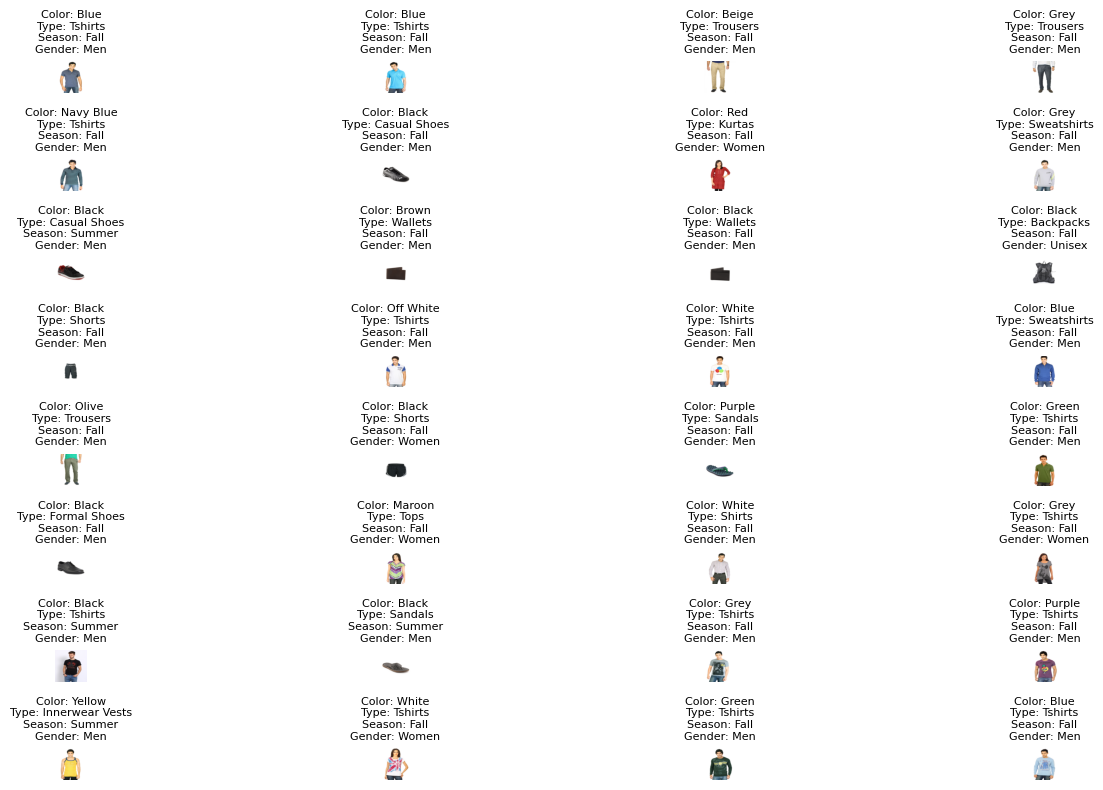

100%|██████████| 6000/6000 [07:06<00:00, 14.07it/s]


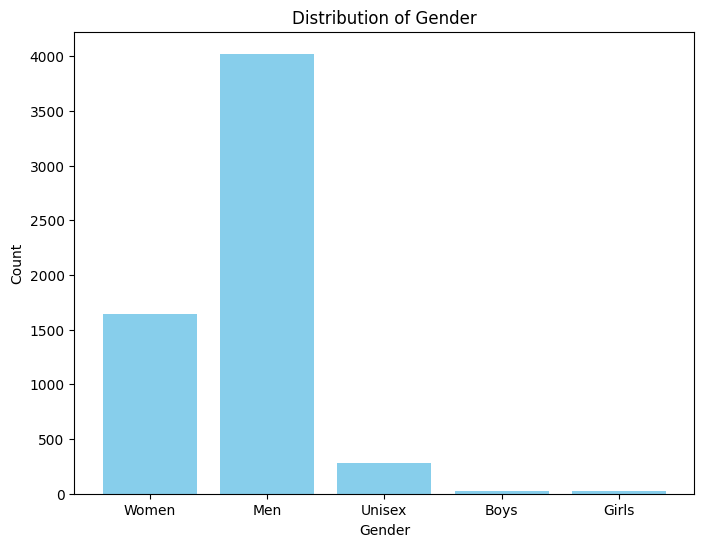

In [ ]:


dataiter = iter(subset_dataloader)
images, labels = next(dataiter)  


def imshow(img, title=None):
    """Helper function to show an image tensor."""
    # Convert tensor to numpy array and transpose to HxWxC
    npimg = img.numpy().transpose((1, 2, 0))
    # Clip the image values to be between 0 and 1
    plt.imshow(np.clip(npimg, 0, 1))
    if title:
        plt.title(title, fontsize=8)
    plt.axis('off')

batch_size = images.shape[0]
cols = 4  # Number of columns in the grid
rows = batch_size // cols + int(batch_size % cols != 0)

plt.figure(figsize=(15, 8))
for idx in range(batch_size):
    plt.subplot(rows, cols, idx + 1)
    # Build a title string from labels for the idx-th image
    title = (f"Color: {labels['color'][idx]}\n"
             f"Type: {labels['type'][idx]}\n"
             f"Season: {labels['season'][idx]}\n"
             f"Gender: {labels['gender'][idx]}")
    imshow(images[idx], title=title)
plt.tight_layout()
plt.show()


gender_counts = collections.Counter()
for i in tqdm(range(len(subset_dataset))):
    _, label = dataset[i]
    gender_counts[label['gender']] += 1

# Create a bar chart of the gender distribution
plt.figure(figsize=(8, 6))
plt.bar(gender_counts.keys(), gender_counts.values(), color='skyblue')
plt.title("Distribution of Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


### More distribution over other labels 


100%|██████████| 6000/6000 [07:36<00:00, 13.13it/s]


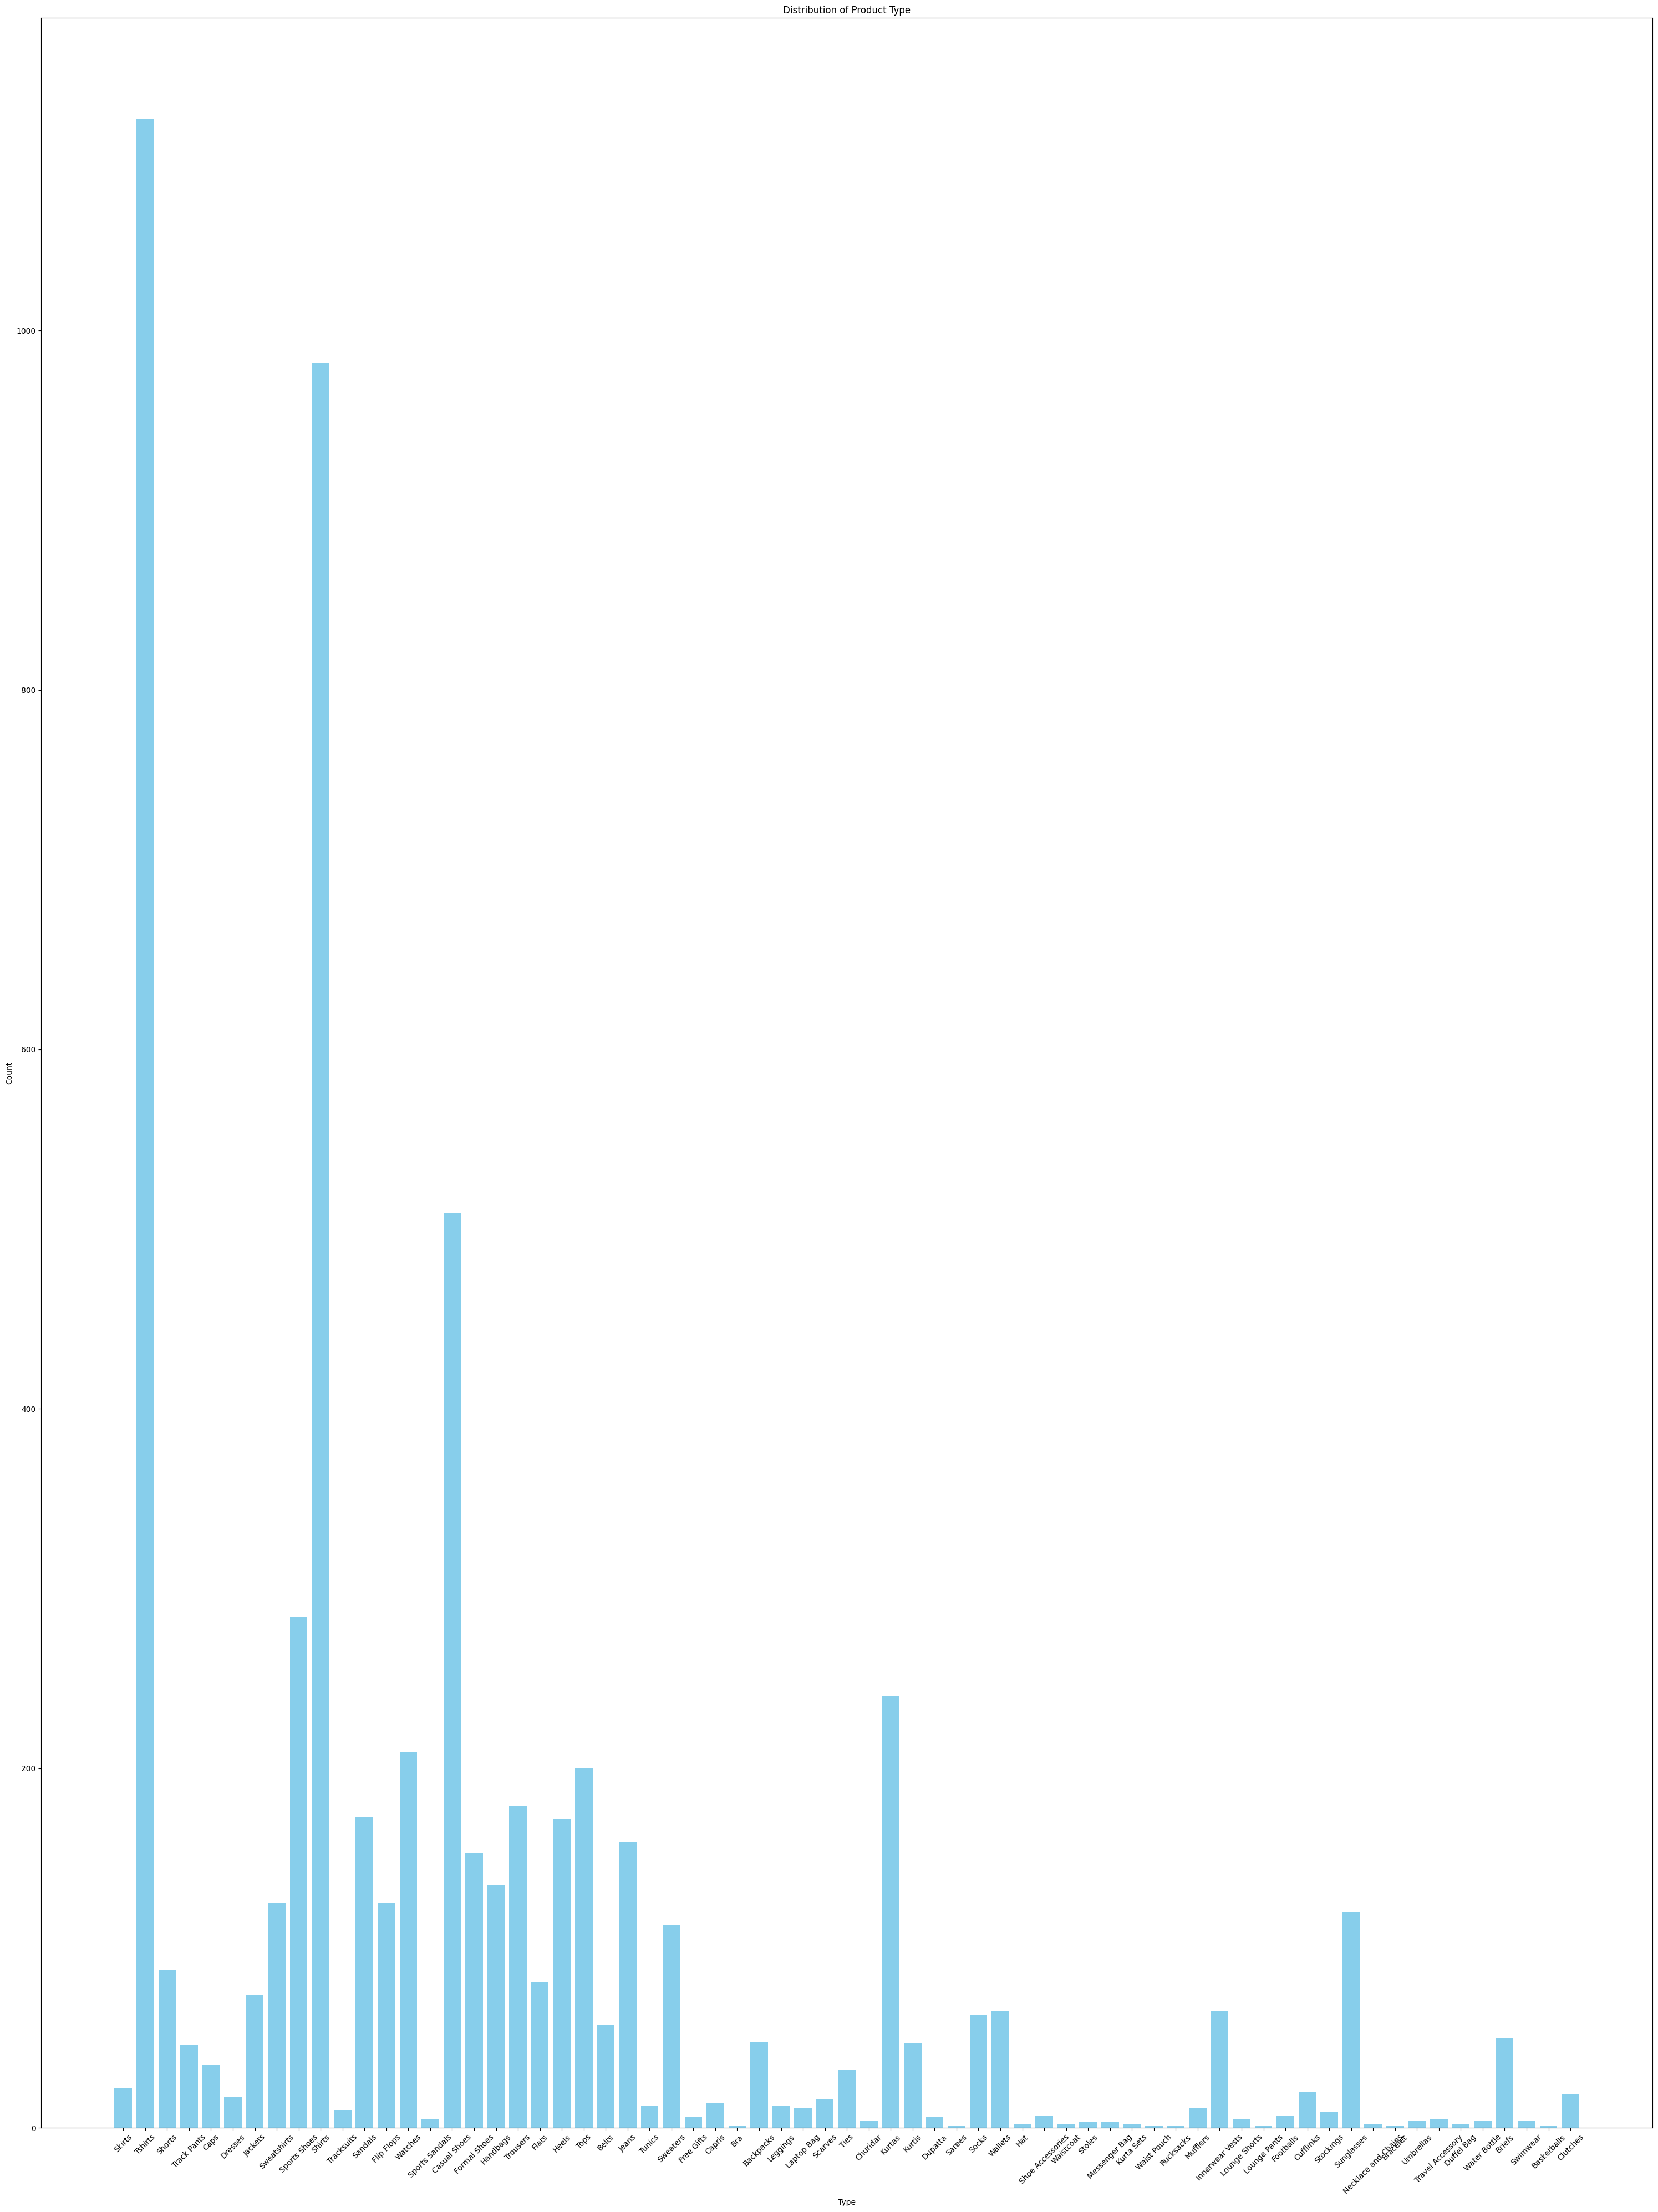

100%|██████████| 6000/6000 [06:34<00:00, 15.21it/s]


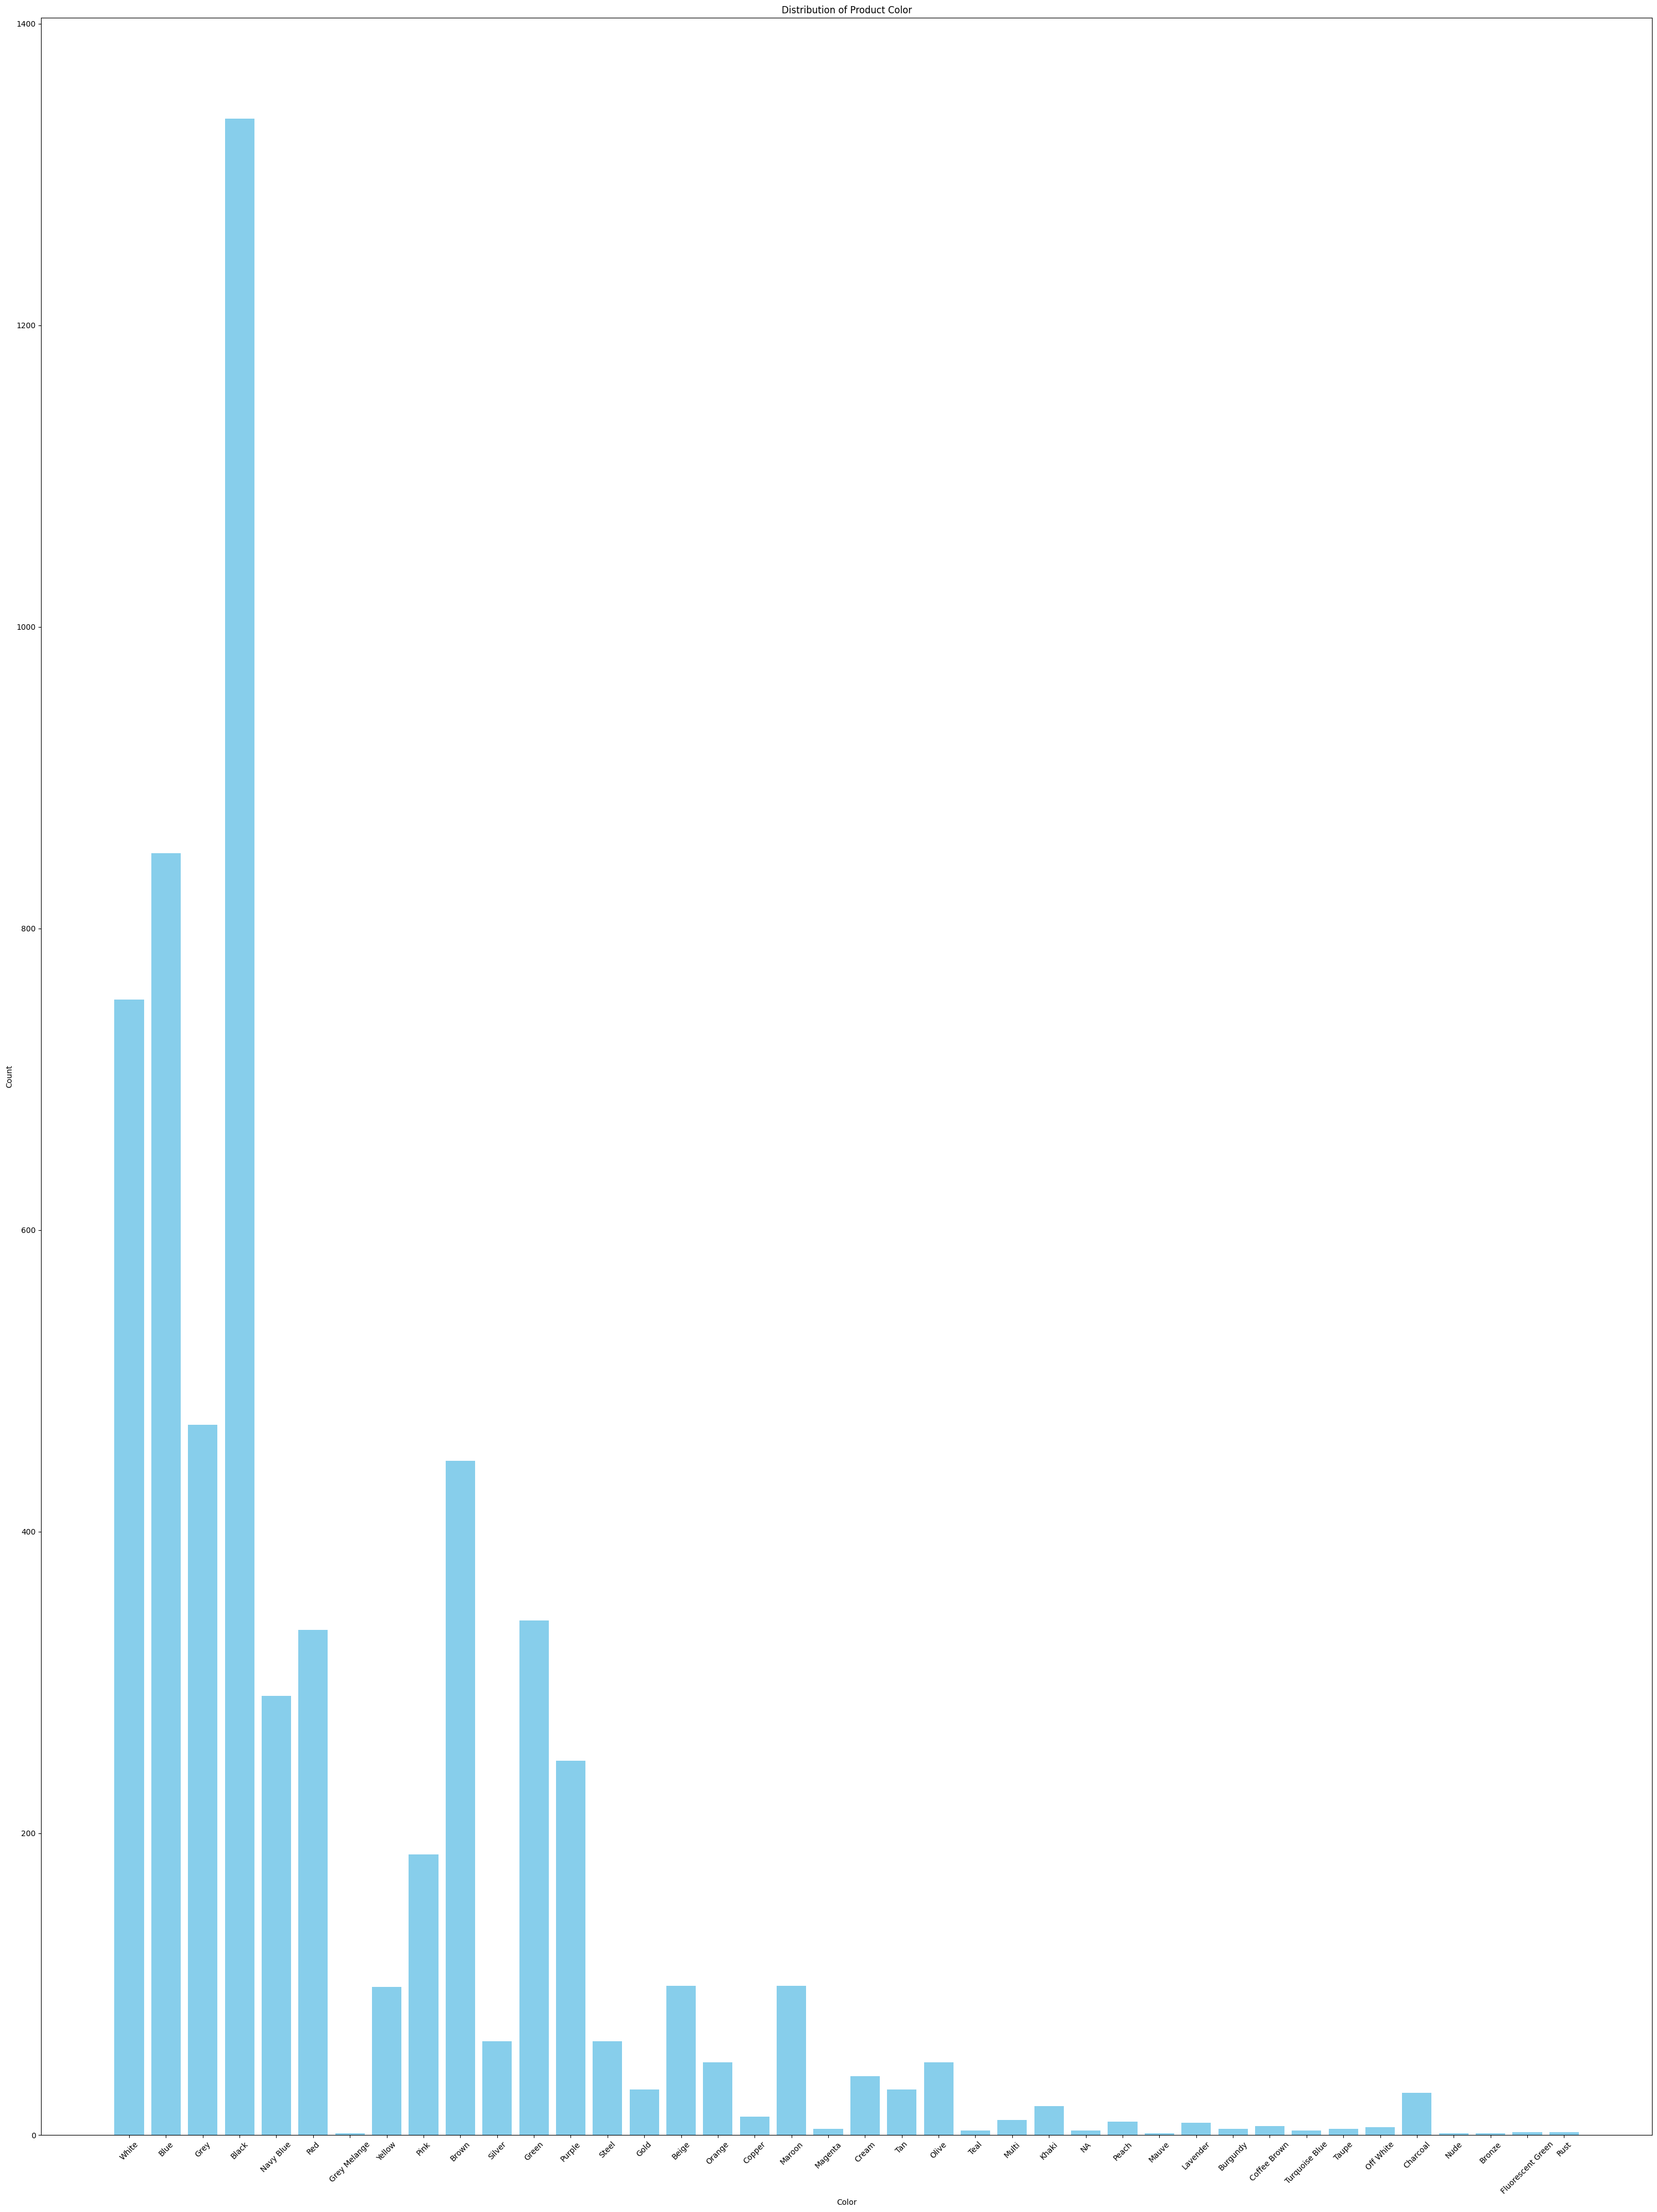

100%|██████████| 6000/6000 [06:26<00:00, 15.54it/s]


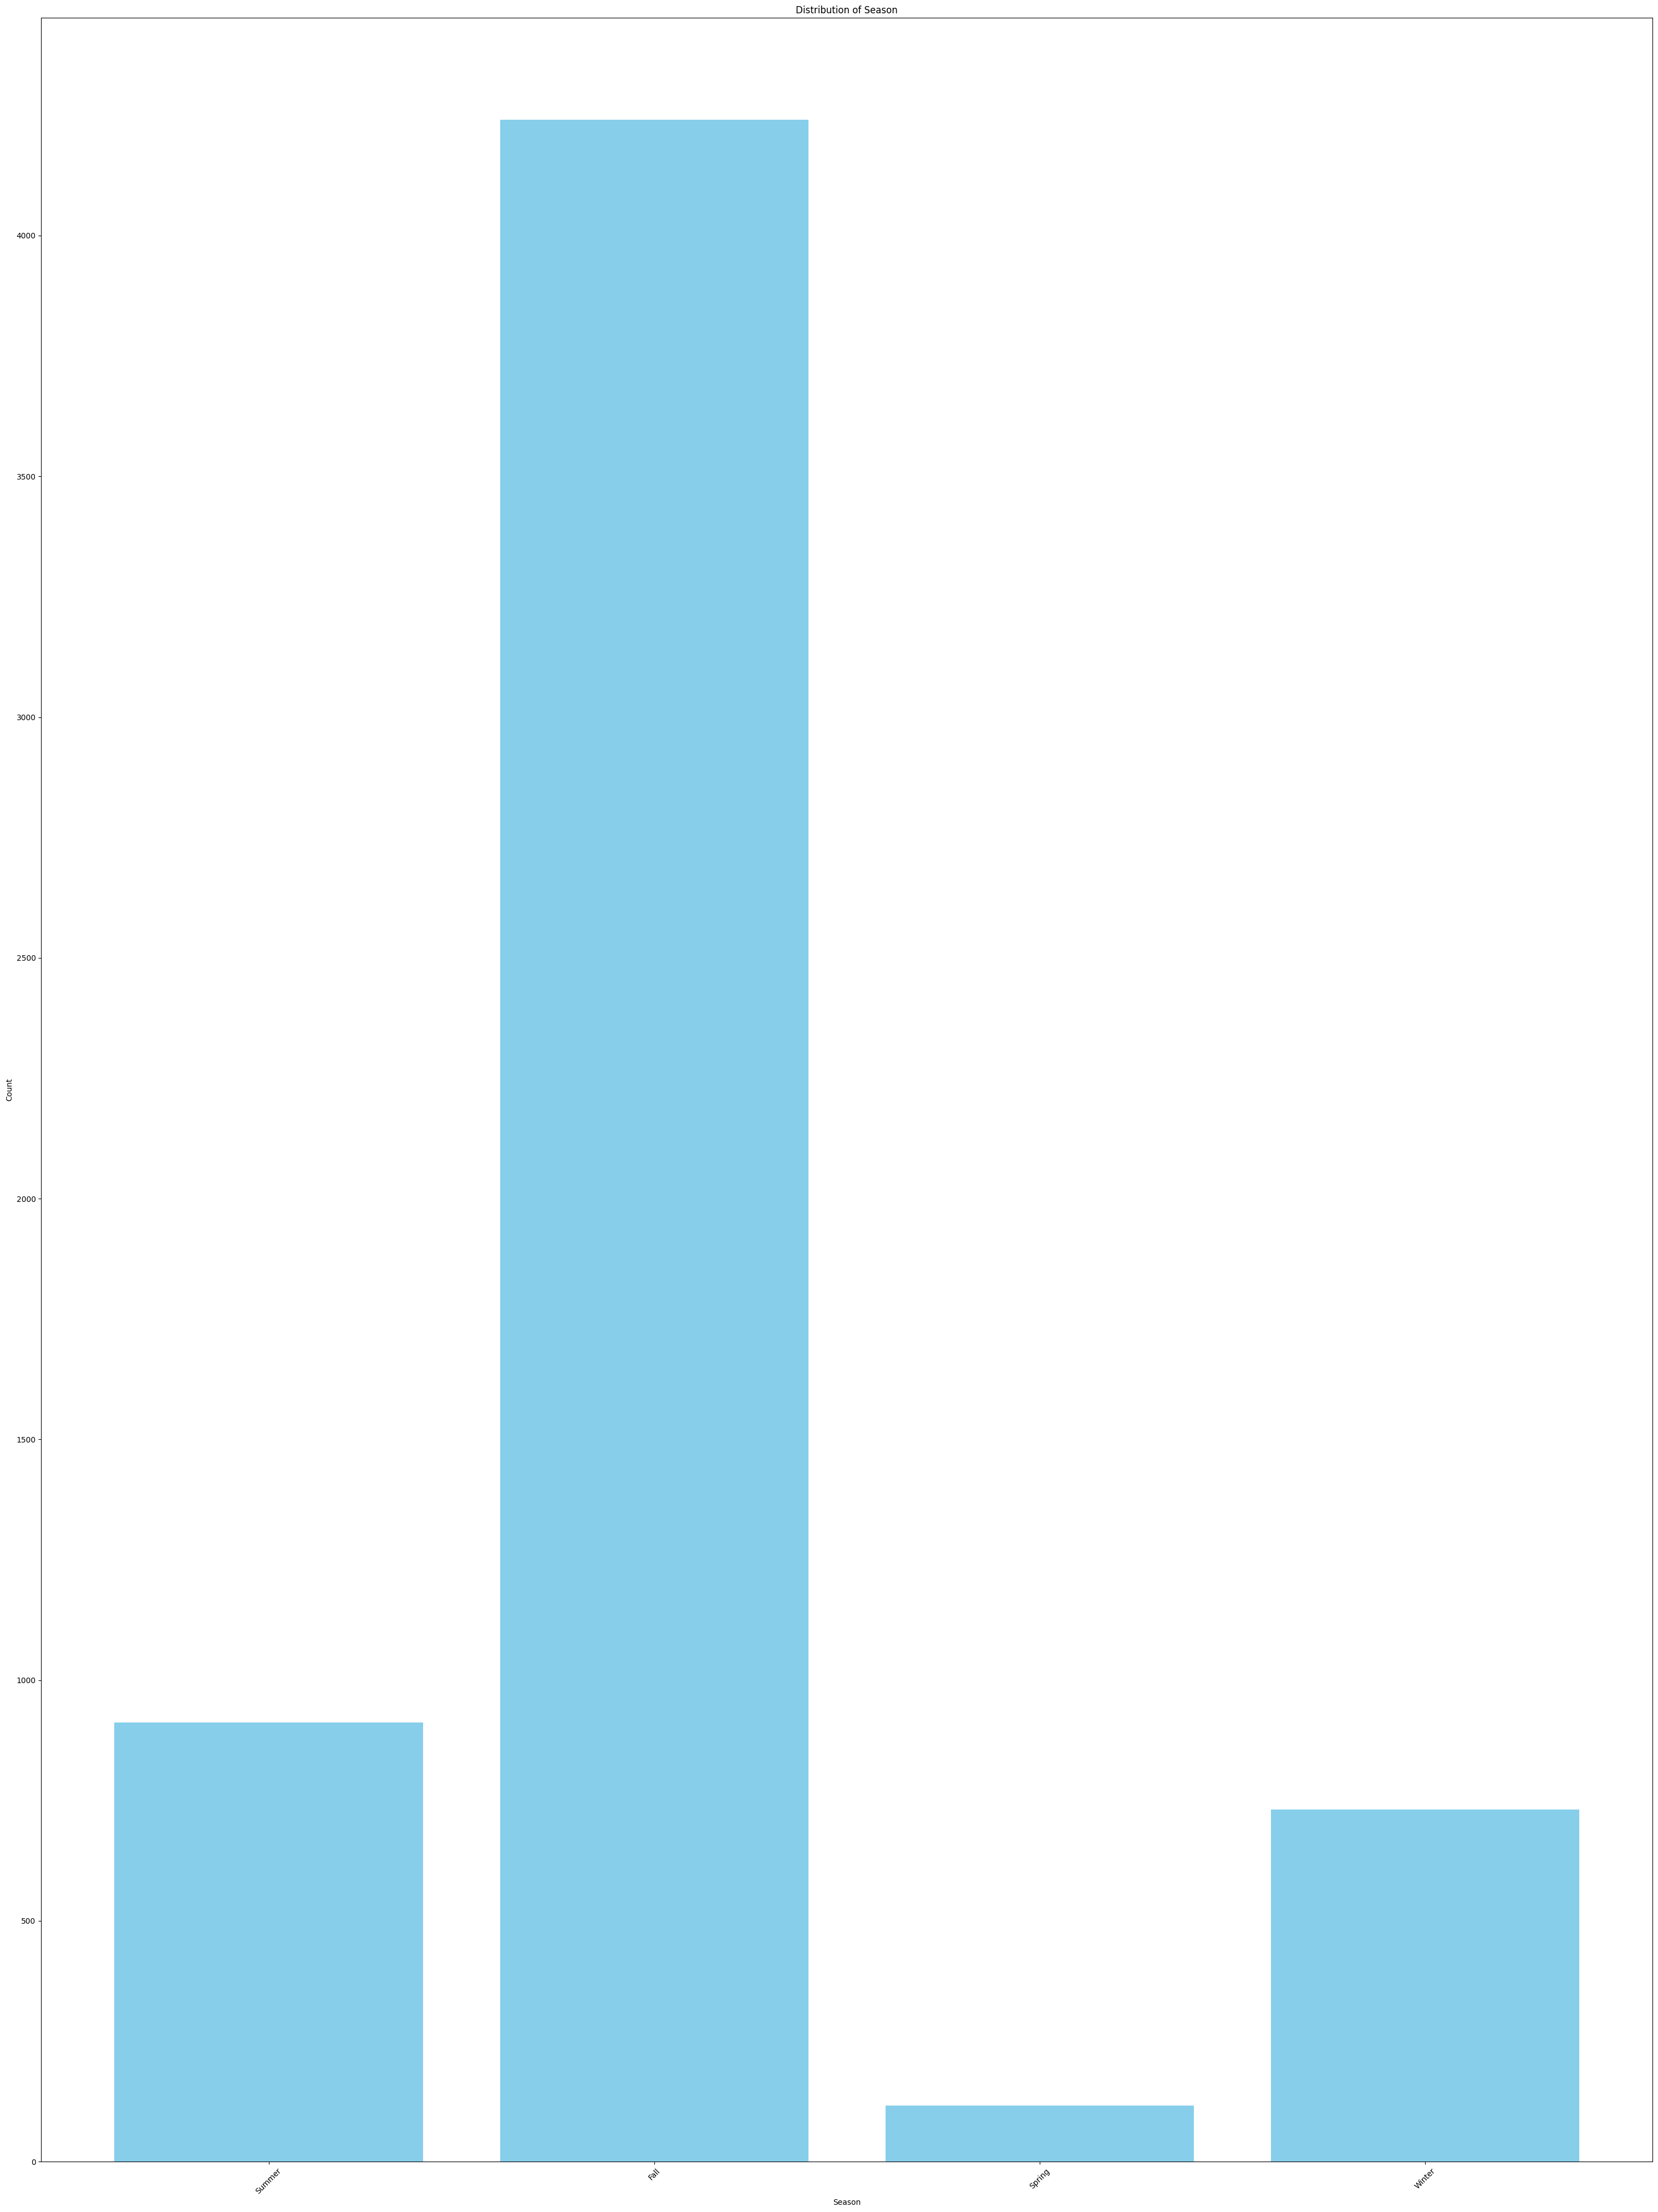

In [ ]:
def plot_attribute_distribution(dataset, attribute_key, title=None):
    
    
    attr_counter = collections.Counter()
    for i in tqdm(range(len(dataset))):
        _, labels = dataset[i]
        attr_value = labels.get(attribute_key, "unknown")
        attr_counter[attr_value] += 1
    
    
    plt.figure(figsize=(30, 40))
    plt.bar(attr_counter.keys(), attr_counter.values(), color='skyblue')
    plt.xlabel(attribute_key.capitalize())
    plt.ylabel("Count")
    plt.title(title if title else f"Distribution of {attribute_key.capitalize()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



plot_attribute_distribution(subset_dataset, attribute_key="type", title="Distribution of Product Type")
plot_attribute_distribution(subset_dataset, attribute_key="color", title="Distribution of Product Color")
plot_attribute_distribution(subset_dataset, attribute_key="season", title="Distribution of Season")

### Pixel Intensity and Entropy plot 

In [ ]:


def compute_pixel_intensity_distribution(image_tensor, bins=256):
    
    distribution = {}
    channels = ["R", "G", "B"]
    
    for c, channel_name in enumerate(channels):
        channel_data = image_tensor[c].numpy().flatten()
        hist, _ = np.histogram(channel_data, bins=bins, range=(0, 1))
        distribution[channel_name] = hist
    return distribution

def compute_entropy(image_tensor, bins=256):
    
    c, h, w = image_tensor.shape
    if c == 3:
        
        r = image_tensor[0].numpy()
        g = image_tensor[1].numpy()
        b = image_tensor[2].numpy()
        gray = 0.299*r + 0.587*g + 0.114*b
    else:
        gray = image_tensor[0].numpy()
        
    gray = gray.flatten()
    
    hist, _ = np.histogram(gray, bins=bins, range=(0, 1), density=True)
    
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist))
    return entropy

def compute_mean_std_per_channel(image_tensor):
    
    stats = {}
    channels = ["R", "G", "B"]
    for c, channel_name in enumerate(channels):
        channel_data = image_tensor[c]
        stats[channel_name] = {
            "mean": channel_data.mean().item(),
            "std": channel_data.std().item()
        }
    return stats



def plot_overall_pixel_intensity_distribution(dataset, bins=256):
    
    total_hist = {"R": np.zeros(bins), "G": np.zeros(bins), "B": np.zeros(bins)}
    num_images = len(dataset)
    
    for i in tqdm(range(num_images)):
        image, _ = dataset[i]
        hist_dict = compute_pixel_intensity_distribution(image, bins=bins)
        for channel in total_hist:
            total_hist[channel] += hist_dict[channel]
    
    
    avg_hist = {ch: total_hist[ch] / num_images for ch in total_hist}
    
    bin_edges = np.linspace(0, 1, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plt.figure(figsize=(12, 4))
    for i, channel in enumerate(["R", "G", "B"]):
        plt.subplot(1, 3, i+1)
        plt.bar(bin_centers, avg_hist[channel], width=1/bins, color=channel.lower())
        plt.title(f"Average {channel} Channel")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def plot_entropy_distribution(dataset, bins=50):
    
    entropy_values = []
    num_images = len(dataset)
    for i in tqdm(range(num_images)):
        image, _ = dataset[i]
        entropy_values.append(compute_entropy(image))
    
    plt.figure(figsize=(8, 6))
    plt.hist(entropy_values, bins=bins, color='purple', edgecolor='black')
    plt.title("Entropy Distribution")
    plt.xlabel("Entropy")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

def plot_mean_std_distribution(dataset):
    
    
    means = {"R": [], "G": [], "B": []}
    stds = {"R": [], "G": [], "B": []}
    num_images = len(dataset)
    
    for i in tqdm(range(num_images)):
        image, _ = dataset[i]
        stats = compute_mean_std_per_channel(image)
        for channel in ["R", "G", "B"]:
            means[channel].append(stats[channel]["mean"])
            stds[channel].append(stats[channel]["std"])
    
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for channel, color in zip(["R", "G", "B"], ['red', 'green', 'blue']):
        plt.hist(means[channel], bins=50, alpha=0.6, color=color, label=channel)
    plt.title("Mean Distribution per Channel")
    plt.xlabel("Mean Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    
    
    plt.subplot(1, 2, 2)
    for channel, color in zip(["R", "G", "B"], ['red', 'green', 'blue']):
        plt.hist(stds[channel], bins=50, alpha=0.6, color=color, label=channel)
    plt.title("Standard Deviation Distribution per Channel")
    plt.xlabel("Standard Deviation")
    plt.ylabel("Frequency")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

100%|██████████| 6000/6000 [06:55<00:00, 14.44it/s]


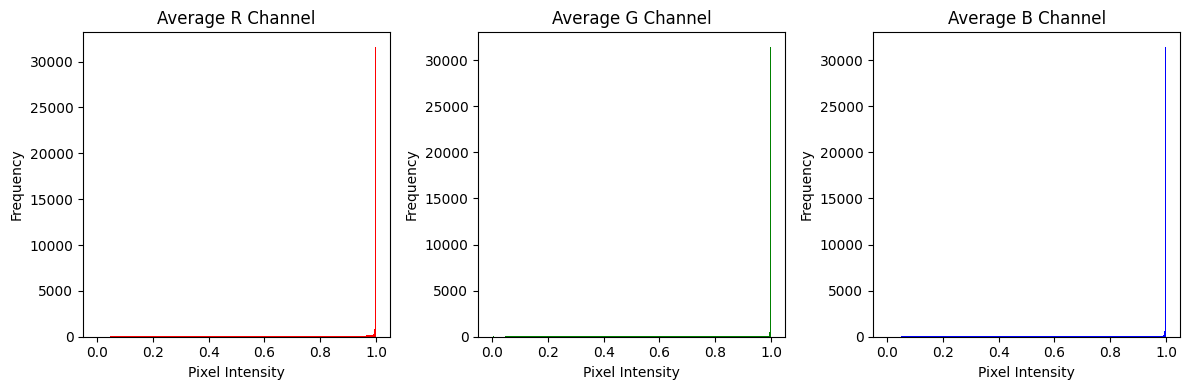

In [ ]:

plot_overall_pixel_intensity_distribution(subset_dataset, bins=256)


100%|██████████| 6000/6000 [06:44<00:00, 14.83it/s]


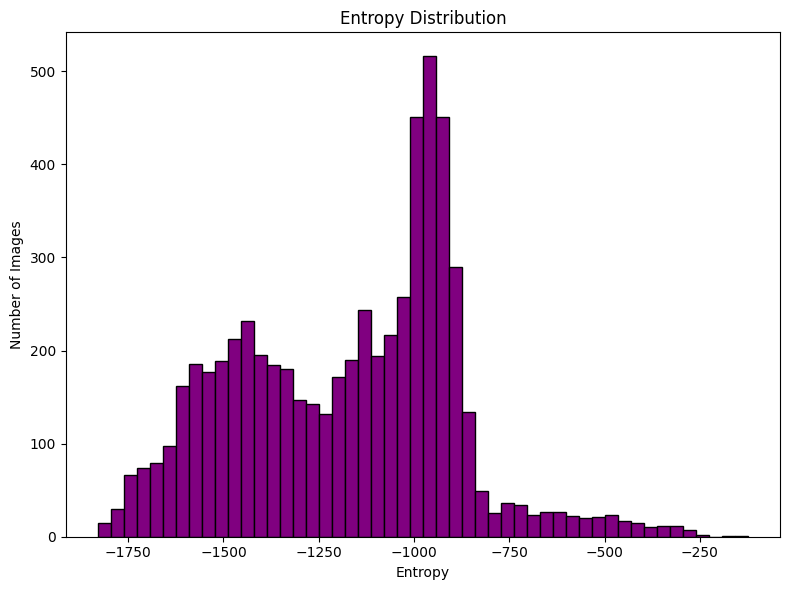

100%|██████████| 6000/6000 [06:45<00:00, 14.81it/s]


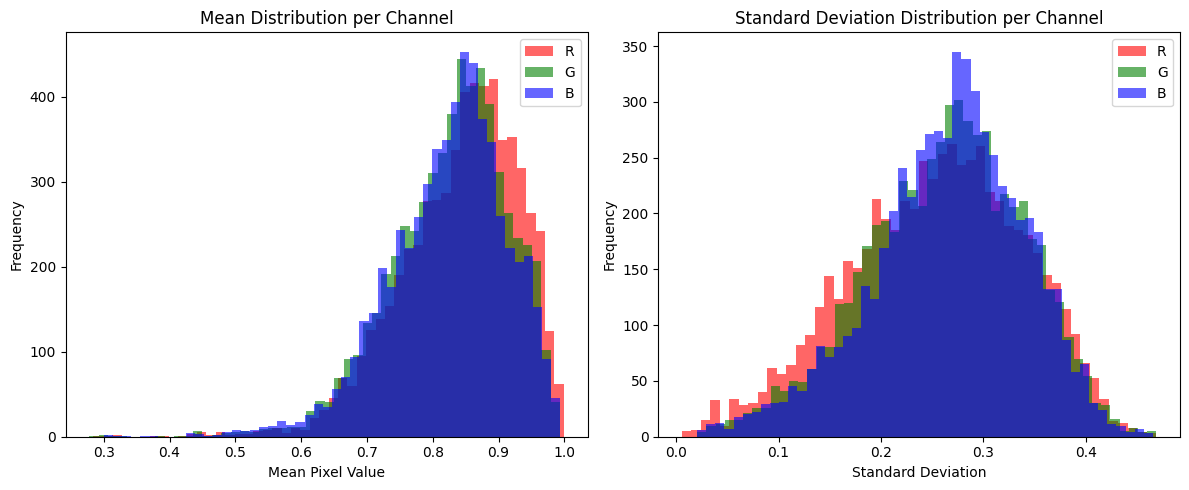

In [ ]:

plot_entropy_distribution(subset_dataset, bins=50)


plot_mean_std_distribution(subset_dataset)

### Top Insights we got of dataset from EDA


#### 1- After checking the size and dimensions of images we got an idea of how much we need to resize it according to our model
#### 2- Image shape also made us clear whether their any uniform images in it 
#### 3- Pixel intensity distribution: Skewed distributions  benefit from normalization. (ours got it skewed)
#### 4 - Entropy Distribution of Images made us clear that it would be easy to classify them with model (less entropy means less information means model doesnt have to work overtime)
#### 5 - Classes Frequency Plot made us understand the distribution of class over the dataset (makes us understand how much confident model will be for certain class)
#### 6 - The mean pixel value tells the overall color tone and brightness of the dataset.
#### 7- SD distribution will tell how much variation exist in dataset.

## Main Code Part

### Class for label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

class FashionLabelEncoder:
    def __init__(self):
        self.encoders = {
            "color": LabelEncoder(),
            "type": LabelEncoder(),
            "season": LabelEncoder(),
            "gender": LabelEncoder()
        }
        self.fitted = False
        
    def fit(self, dataset):
        
        if self.fitted:
            return
        
        label_collections = {
            "color": [],
            "type": [],
            "season": [],
            "gender": []
        }
        
        
        print("Fitting label encoders...")
        for i in tqdm(range(len(dataset))):
            _, labels = dataset[i]
            for category in label_collections:
                label_collections[category].append(labels[category])
        
        
        for category, values in label_collections.items():
            self.encoders[category].fit(values)
            
        self.fitted = True
        
        
        for category, encoder in self.encoders.items():
            print(f"{category} classes: {len(encoder.classes_)}")
            print(f"First 10 {category} mappings: {dict(zip(encoder.classes_[:10], range(10)))}")
    
    def encode(self, labels):
        
        if not self.fitted:
            raise ValueError("Encoder must be fitted before encoding")
            
        encoded = {}
        for category, value in labels.items():
            try:
                encoded[category] = self.encoders[category].transform([value])[0]
            except ValueError:
                
                encoded[category] = -1
                
        return encoded
    
    def decode(self, encoded_labels):
        
        if not self.fitted:
            raise ValueError("Encoder must be fitted before decoding")
            
        decoded = {}
        for category, value in encoded_labels.items():
            if value == -1:
                decoded[category] = "unknown"
            else:
                decoded[category] = self.encoders[category].inverse_transform([value])[0]
                
        return decoded
    
    def get_num_classes(self):
        
        return {category: len(encoder.classes_) for category, encoder in self.encoders.items()}

### Neural Network Architecture

In [ ]:
import torch.nn as nn
from torchvision import models, transforms
import torch.optim as optim
import torch
class FashionClassifier(nn.Module):
    def __init__(self, num_classes_dict, backbone="resnet50", pretrained=True):
        super(FashionClassifier, self).__init__()
        
        
        if backbone == "resnet18":
            base_model = models.resnet18(pretrained=pretrained)
        elif backbone == "resnet34":
            base_model = models.resnet34(pretrained=pretrained)
        elif backbone == "resnet50":
            base_model = models.resnet50(pretrained=pretrained)
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
        
        
        self.features = nn.Sequential(*list(base_model.children())[:-1])
        
        
        self.feature_dim = base_model.fc.in_features
        
        # Create separate classification heads for each attribute
        self.color_classifier = nn.Linear(self.feature_dim, num_classes_dict["color"])
        self.type_classifier = nn.Linear(self.feature_dim, num_classes_dict["type"])
        self.season_classifier = nn.Linear(self.feature_dim, num_classes_dict["season"])
        self.gender_classifier = nn.Linear(self.feature_dim, num_classes_dict["gender"])
        
    def forward(self, x):
        
        features = self.features(x)
        features = torch.flatten(features, 1)
        
        # Get predictions for each attribute
        color_output = self.color_classifier(features)
        type_output = self.type_classifier(features)
        season_output = self.season_classifier(features)
        gender_output = self.gender_classifier(features)
        
        return {
            "color": color_output,
            "type": type_output,
            "season": season_output,
            "gender": gender_output
        }


### Training loop function

In [ ]:
def train_fashion_classifier():
    
    image_dir = "./Dataset_highres/fashion-dataset/fashion-dataset/images"
    styles_dir = "./Dataset_highres/fashion-dataset/fashion-dataset/styles"
    
    
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.004
    n = 20000 
    
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    
    full_dataset = FashionDataset(image_dir, styles_dir, transform=transform)
    
    
    if n < len(full_dataset):
        indices = list(range(n))
        dataset = torch.utils.data.Subset(full_dataset, indices)
        print(f"Dataset limited to {n} samples")
    else:
        dataset = full_dataset
    
    
    label_encoder = FashionLabelEncoder()
    label_encoder.fit(dataset)
    
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    
    num_classes = label_encoder.get_num_classes()
    print("Number of classes per category:", num_classes)
    
    
    model = FashionClassifier(num_classes, pretrained=True)
    model = model.to(device)
    
   
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = {
            "color": 0,
            "type": 0,
            "season": 0,
            "gender": 0
        }
        
        for batch_idx, batch_data in enumerate(train_loader):
            inputs, labels = batch_data
            inputs = inputs.to(device)
            
            
            if batch_idx == 0:
                print(f"Type of labels: {type(labels)}")
                print(f"First label content: {labels[0] if isinstance(labels, list) else labels}")
            
            batch_encoded_labels = {}
            
            
            for category in ["color", "type", "season", "gender"]:
                
                encoded_labels_list = []
                
                
                for i in range(len(inputs)):
                    
                    if isinstance(labels, dict):
                        
                        label_value = labels[category][i]
                    else:
                        
                        label_value = labels[i][category]
                    
                   
                    try:
                        encoded_value = label_encoder.encoders[category].transform([label_value])[0]
                    except ValueError:
                        
                        encoded_value = -1
                    
                    encoded_labels_list.append(encoded_value)
                
                
                batch_encoded_labels[category] = torch.tensor(encoded_labels_list, dtype=torch.long).to(device)
            
            
            optimizer.zero_grad()
            
            
            outputs = model(inputs)
            
            
            loss = 0
            batch_corrects = {}
            for category in ["color", "type", "season", "gender"]:
                category_loss = criterion(outputs[category], batch_encoded_labels[category])
                loss += category_loss
                
                
                _, preds = torch.max(outputs[category], 1)
                correct = torch.sum(preds == batch_encoded_labels[category]).item()
                running_corrects[category] += correct
                batch_corrects[category] = correct / inputs.size(0)
            
            
            loss.backward()
            optimizer.step()
            
           
            running_loss += loss.item() * inputs.size(0)
            batch_loss = loss.item()
            
            if (batch_idx + 1) % 500 == 0 or (batch_idx + 1) == len(train_loader):
                print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {batch_loss:.4f}")
                for category in ["color", "type", "season", "gender"]:
                    print(f"    {category} Acc: {batch_corrects[category]:.4f}")
        
        
        epoch_loss = running_loss / len(train_dataset)
        print(f"\nTraining - Epoch {epoch+1} - Loss: {epoch_loss:.4f}")
        for category in ["color", "type", "season", "gender"]:
            epoch_acc = running_corrects[category] / len(train_dataset)
            print(f"Training - {category} Acc: {epoch_acc:.4f}")
        
        
        model.eval()
        val_loss = 0.0
        val_corrects = {
            "color": 0,
            "type": 0,
            "season": 0,
            "gender": 0
        }
        
        with torch.no_grad():
            for batch_data in val_loader:
                inputs, labels = batch_data
                inputs = inputs.to(device)
                
                
                batch_encoded_labels = {}
                
                for category in ["color", "type", "season", "gender"]:
                    encoded_labels_list = []
                    
                    for i in range(len(inputs)):
                        if isinstance(labels, dict):
                            label_value = labels[category][i]
                        else:
                            label_value = labels[i][category]
                        
                        try:
                            encoded_value = label_encoder.encoders[category].transform([label_value])[0]
                        except ValueError:
                            encoded_value = -1
                        
                        encoded_labels_list.append(encoded_value)
                    
                    batch_encoded_labels[category] = torch.tensor(encoded_labels_list, dtype=torch.long).to(device)
                
                
                outputs = model(inputs)
                
                
                loss = 0
                for category in ["color", "type", "season", "gender"]:
                    category_loss = criterion(outputs[category], batch_encoded_labels[category])
                    loss += category_loss
                    
                    
                    _, preds = torch.max(outputs[category], 1)
                    val_corrects[category] += torch.sum(preds == batch_encoded_labels[category]).item()
                
                val_loss += loss.item() * inputs.size(0)
        
        
        epoch_val_loss = val_loss / len(val_dataset)
        print(f"\nValidation - Epoch {epoch+1} - Loss: {epoch_val_loss:.4f}")
        for category in ["color", "type", "season", "gender"]:
            epoch_val_acc = val_corrects[category] / len(val_dataset)
            print(f"Validation - {category} Acc: {epoch_val_acc:.4f}")
    
    print("\nTraining complete!")
    
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'num_classes': num_classes,
    }, 'fashion_classifier_model_.pth')
    
    
    import pickle
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    
    return model, label_encoder


train_fashion_classifier()

Using device: cuda:0
Dataset limited to 20000 samples
Fitting label encoders...


100%|██████████| 20000/20000 [19:54<00:00, 16.74it/s] 
c:\Users\Priyanshu singh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Priyanshu singh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


color classes: 44
First 10 color mappings: {'Beige': 0, 'Black': 1, 'Blue': 2, 'Bronze': 3, 'Brown': 4, 'Burgundy': 5, 'Charcoal': 6, 'Coffee Brown': 7, 'Copper': 8, 'Cream': 9}
type classes: 89
First 10 type mappings: {'Accessory Gift Set': 0, 'Backpacks': 1, 'Basketballs': 2, 'Belts': 3, 'Blazers': 4, 'Boxers': 5, 'Bra': 6, 'Bracelet': 7, 'Briefs': 8, 'Camisoles': 9}
season classes: 4
First 10 season mappings: {'Fall': 0, 'Spring': 1, 'Summer': 2, 'Winter': 3}
gender classes: 5
First 10 gender mappings: {'Boys': 0, 'Girls': 1, 'Men': 2, 'Unisex': 3, 'Women': 4}
Number of classes per category: {'color': 44, 'type': 89, 'season': 4, 'gender': 5}


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['Green', 'Pink', 'Black', 'Pink', 'Brown', 'Black', 'Black', 'White', 'Navy Blue', 'Black', 'Black', 'Grey', 'Blue', 'Olive', 'Maroon', 'Purple', 'Black', 'Green', 'Blue', 'Black', 'Blue', 'Blue', 'Brown', 'Navy Blue', 'Purple', 'White', 'Black', 'Green', 'Grey', 'Brown', 'Green', 'Blue'], 'type': ['Kurtas', 'Tshirts', 'Deodorant', 'Flip Flops', 'Kurtas', 'Sports Shoes', 'Watches', 'Tshirts', 'Sports Shoes', 'Clutches', 'Track Pants', 'Tshirts', 'Casual Shoes', 'Sandals', 'Tshirts', 'Sweatshirts', 'Sunglasses', 'Shirts', 'Tshirts', 'Sports Shoes', 'Kurtas', 'Tops', 'Kurtas', 'Suspenders', 'Handbags', 'Tshirts', 'Wallets', 'Sweaters', 'Trunk', 'Wallets', 'Tshirts', 'Shirts'], 'season': ['Fall', 'Winter', 'Spring', 'Fall', 'Summer', 'Fall', 'Winter', 'Summer', 'Summer', 'Winter', 'Fall', 'Summer', 'Summer', 'Summer', 'Fall', 'Fall', 'Winter', 'Summer', 'Summer', 'Fall', 'Summer', 'Winter', 'Su

 10%|█         | 1/10 [24:28<3:40:12, 1468.09s/it]


Validation - Epoch 1 - Loss: 4.9243
Validation - color Acc: 0.4935
Validation - type Acc: 0.5485
Validation - season Acc: 0.5335
Validation - gender Acc: 0.7775

Epoch 2/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['Black', 'White', 'Black', 'Blue', 'Green', 'Blue', 'Blue', 'Black', 'Yellow', 'Black', 'Red', 'Purple', 'Black', 'White', 'White', 'Brown', 'Purple', 'Green', 'Black', 'Brown', 'Purple', 'Off White', 'Black', 'Grey', 'White', 'Brown', 'Brown', 'Black', 'Blue', 'Black', 'Black', 'Gold'], 'type': ['Deodorant', 'Socks', 'Flats', 'Shirts', 'Tshirts', 'Shorts', 'Jeans', 'Watches', 'Innerwear Vests', 'Sandals', 'Handbags', 'Wallets', 'Trousers', 'Sports Shoes', 'Sports Shoes', 'Sunglasses', 'Tshirts', 'Tshirts', 'Casual Shoes', 'Wallets', 'Perfume and Body Mist', 'Tshirts', 'Sunglasses', 'Trunk', 'Sports Shoes', 'Handbags', 'Kurtas', 'Laptop Bag', 'Sports Shoes', 'Flats', 'Tshirts', 'Watches'], 'season': ['Spring', 'Summer', 'Winter', 'F

 20%|██        | 2/10 [49:12<3:16:59, 1477.47s/it]


Validation - Epoch 2 - Loss: 8.8849
Validation - color Acc: 0.2625
Validation - type Acc: 0.3098
Validation - season Acc: 0.4580
Validation - gender Acc: 0.7210

Epoch 3/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['Beige', 'White', 'Blue', 'Blue', 'Brown', 'Yellow', 'Black', 'Black', 'Black', 'Silver', 'Grey', 'Green', 'Black', 'Blue', 'Steel', 'Blue', 'Navy Blue', 'Blue', 'Blue', 'Pink', 'Grey', 'White', 'Black', 'Steel', 'Beige', 'Purple', 'Red', 'Brown', 'Grey', 'Navy Blue', 'Black', 'White'], 'type': ['Leggings', 'Sports Shoes', 'Tshirts', 'Backpacks', 'Wallets', 'Tshirts', 'Casual Shoes', 'Kurtas', 'Watches', 'Watches', 'Trousers', 'Tshirts', 'Shirts', 'Tshirts', 'Watches', 'Shirts', 'Tshirts', 'Tshirts', 'Mobile Pouch', 'Accessory Gift Set', 'Sunglasses', 'Casual Shoes', 'Tshirts', 'Watches', 'Bra', 'Tshirts', 'Flats', 'Wallets', 'Tshirts', 'Mufflers', 'Clutches', 'Bra'], 'season': ['Fall', 'Summer', 'Fall', 'Fall', 'Winter', 'Fall', 'F

 30%|███       | 3/10 [1:13:55<2:52:41, 1480.20s/it]


Validation - Epoch 3 - Loss: 3.7643
Validation - color Acc: 0.5823
Validation - type Acc: 0.7117
Validation - season Acc: 0.6005
Validation - gender Acc: 0.8423

Epoch 4/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['Red', 'Black', 'Grey', 'Olive', 'Red', 'White', 'Purple', 'Grey', 'Pink', 'Grey', 'Blue', 'Black', 'Blue', 'Mustard', 'Olive', 'Grey', 'White', 'Green', 'Yellow', 'White', 'White', 'Brown', 'Black', 'Black', 'Beige', 'Purple', 'Grey', 'Grey', 'Rust', 'White', 'Orange', 'White'], 'type': ['Sweatshirts', 'Caps', 'Casual Shoes', 'Handbags', 'Handbags', 'Socks', 'Tshirts', 'Track Pants', 'Kurtas', 'Kurtas', 'Shirts', 'Sports Shoes', 'Kurtis', 'Kurtas', 'Shorts', 'Sports Shoes', 'Sports Shoes', 'Tshirts', 'Shirts', 'Shirts', 'Tshirts', 'Handbags', 'Perfume and Body Mist', 'Wallets', 'Heels', 'Handbags', 'Shorts', 'Shirts', 'Kurtas', 'Sports Shoes', 'Tshirts', 'Sports Shoes'], 'season': ['Summer', 'Summer', 'Summer', 'Winter', 'Winter', 

 40%|████      | 4/10 [1:38:52<2:28:40, 1486.76s/it]


Validation - Epoch 4 - Loss: 3.5114
Validation - color Acc: 0.6030
Validation - type Acc: 0.7248
Validation - season Acc: 0.6178
Validation - gender Acc: 0.8203

Epoch 5/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['White', 'Grey', 'Purple', 'Charcoal', 'Blue', 'Silver', 'Purple', 'Green', 'Purple', 'Black', 'Black', 'Blue', 'Blue', 'Black', 'White', 'Grey', 'Brown', 'Magenta', 'Black', 'Black', 'Brown', 'Steel', 'Black', 'Maroon', 'White', 'Purple', 'Red', 'Black', 'Red', 'White', 'Black', 'Grey'], 'type': ['Shorts', 'Sports Shoes', 'Shirts', 'Tshirts', 'Tshirts', 'Heels', 'Tshirts', 'Tshirts', 'Shirts', 'Watches', 'Backpacks', 'Accessory Gift Set', 'Tshirts', 'Innerwear Vests', 'Socks', 'Casual Shoes', 'Handbags', 'Tops', 'Clutches', 'Belts', 'Wallets', 'Cufflinks', 'Belts', 'Kurtas', 'Casual Shoes', 'Mobile Pouch', 'Kurtas', 'Backpacks', 'Shirts', 'Sports Shoes', 'Casual Shoes', 'Casual Shoes'], 'season': ['Summer', 'Summer', 'Fall', 'Summe

 50%|█████     | 5/10 [2:03:42<2:03:59, 1487.80s/it]


Validation - Epoch 5 - Loss: 3.8487
Validation - color Acc: 0.5487
Validation - type Acc: 0.7083
Validation - season Acc: 0.5875
Validation - gender Acc: 0.8230

Epoch 6/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['Green', 'Blue', 'Black', 'Brown', 'Charcoal', 'Black', 'Grey', 'Blue', 'White', 'Beige', 'Lavender', 'Black', 'Brown', 'Blue', 'Green', 'Red', 'White', 'Brown', 'Brown', 'Grey', 'Black', 'Black', 'Multi', 'Yellow', 'Blue', 'White', 'Blue', 'Purple', 'Brown', 'Grey', 'Green', 'Blue'], 'type': ['Kurtas', 'Shirts', 'Tshirts', 'Sunglasses', 'Trousers', 'Perfume and Body Mist', 'Tops', 'Tshirts', 'Sports Shoes', 'Shorts', 'Shirts', 'Sports Shoes', 'Belts', 'Shirts', 'Tops', 'Shirts', 'Sports Shoes', 'Casual Shoes', 'Wallets', 'Jeans', 'Handbags', 'Shirts', 'Kurtas', 'Tshirts', 'Jeans', 'Tshirts', 'Briefs', 'Caps', 'Belts', 'Tshirts', 'Tshirts', 'Tshirts'], 'season': ['Fall', 'Fall', 'Summer', 'Winter', 'Summer', 'Spring', 'Winter', 'Fal

 60%|██████    | 6/10 [2:28:28<1:39:09, 1487.28s/it]


Validation - Epoch 6 - Loss: 8.7251
Validation - color Acc: 0.2865
Validation - type Acc: 0.2960
Validation - season Acc: 0.4198
Validation - gender Acc: 0.7562

Epoch 7/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['White', 'Black', 'Maroon', 'Green', 'Grey', 'Black', 'Red', 'Black', 'Red', 'Blue', 'Black', 'Blue', 'Black', 'Green', 'Pink', 'Steel', 'Purple', 'White', 'Black', 'Purple', 'Black', 'Blue', 'Pink', 'Red', 'Black', 'Blue', 'Black', 'White', 'Black', 'Blue', 'Maroon', 'Brown'], 'type': ['Trunk', 'Sandals', 'Kurtas', 'Casual Shoes', 'Sweatshirts', 'Suspenders', 'Trunk', 'Socks', 'Tshirts', 'Sports Shoes', 'Formal Shoes', 'Tshirts', 'Sports Shoes', 'Flip Flops', 'Tops', 'Free Gifts', 'Handbags', 'Shirts', 'Casual Shoes', 'Leggings', 'Sunglasses', 'Tshirts', 'Scarves', 'Dupatta', 'Handbags', 'Briefs', 'Handbags', 'Tshirts', 'Watches', 'Shirts', 'Suspenders', 'Heels'], 'season': ['Summer', 'Fall', 'Fall', 'Fall', 'Fall', 'Summer', 'Summ

 70%|███████   | 7/10 [2:53:06<1:14:12, 1484.24s/it]


Validation - Epoch 7 - Loss: 3.3995
Validation - color Acc: 0.5630
Validation - type Acc: 0.7540
Validation - season Acc: 0.6877
Validation - gender Acc: 0.8638

Epoch 8/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['Blue', 'Brown', 'Blue', 'Black', 'Black', 'Grey', 'Black', 'White', 'Black', 'Magenta', 'White', 'Gold', 'Navy Blue', 'Navy Blue', 'White', 'Blue', 'Black', 'Black', 'Brown', 'Navy Blue', 'Red', 'Grey', 'Red', 'Black', 'White', 'Blue', 'Maroon', 'Pink', 'Green', 'Red', 'Maroon', 'Black'], 'type': ['Stoles', 'Sandals', 'Handbags', 'Formal Shoes', 'Casual Shoes', 'Dresses', 'Tshirts', 'Shirts', 'Tshirts', 'Handbags', 'Briefs', 'Watches', 'Shirts', 'Ties', 'Shirts', 'Shirts', 'Bra', 'Casual Shoes', 'Wallets', 'Shirts', 'Casual Shoes', 'Tshirts', 'Flip Flops', 'Tshirts', 'Tops', 'Shirts', 'Kurtas', 'Handbags', 'Flip Flops', 'Kurtas', 'Shirts', 'Backpacks'], 'season': ['Summer', 'Winter', 'Winter', 'Summer', 'Fall', 'Fall', 'Fall', 'Fal

 80%|████████  | 8/10 [3:17:57<49:32, 1486.46s/it]  


Validation - Epoch 8 - Loss: 11.6778
Validation - color Acc: 0.2315
Validation - type Acc: 0.3250
Validation - season Acc: 0.4525
Validation - gender Acc: 0.6275

Epoch 9/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['Navy Blue', 'White', 'Grey', 'Brown', 'Brown', 'Black', 'Purple', 'Olive', 'White', 'Green', 'Red', 'Red', 'Red', 'Blue', 'Purple', 'Grey', 'Black', 'Grey', 'Black', 'Grey', 'Blue', 'Silver', 'Blue', 'Black', 'Peach', 'Black', 'Navy Blue', 'Steel', 'Purple', 'Maroon', 'Black', 'Blue'], 'type': ['Casual Shoes', 'Shirts', 'Tshirts', 'Clutches', 'Sandals', 'Flats', 'Caps', 'Sandals', 'Casual Shoes', 'Tshirts', 'Tshirts', 'Tshirts', 'Tunics', 'Handbags', 'Handbags', 'Sandals', 'Tops', 'Track Pants', 'Flip Flops', 'Briefs', 'Jeans', 'Heels', 'Casual Shoes', 'Scarves', 'Kurtas', 'Formal Shoes', 'Sweaters', 'Sunglasses', 'Sweatshirts', 'Kurtas', 'Socks', 'Shirts'], 'season': ['Summer', 'Fall', 'Fall', 'Winter', 'Winter', 'Fall', 'Fall', 

 90%|█████████ | 9/10 [3:43:40<25:04, 1504.01s/it]


Validation - Epoch 9 - Loss: 2.6931
Validation - color Acc: 0.6747
Validation - type Acc: 0.8295
Validation - season Acc: 0.7073
Validation - gender Acc: 0.8742

Epoch 10/10
--------------------
Type of labels: <class 'dict'>
First label content: {'color': ['Blue', 'Purple', 'Purple', 'Red', 'Green', 'Brown', 'Navy Blue', 'Silver', 'Black', 'Silver', 'Blue', 'Green', 'Brown', 'Maroon', 'Black', 'Black', 'Navy Blue', 'Multi', 'Black', 'Olive', 'Red', 'Grey', 'Silver', 'Navy Blue', 'Brown', 'Red', 'Brown', 'Grey', 'Grey', 'White', 'Red', 'Blue'], 'type': ['Dupatta', 'Sweaters', 'Tops', 'Tshirts', 'Tshirts', 'Backpacks', 'Shirts', 'Earrings', 'Watches', 'Sports Shoes', 'Kurtis', 'Tshirts', 'Casual Shoes', 'Handbags', 'Backpacks', 'Tshirts', 'Capris', 'Kurtas', 'Handbags', 'Shirts', 'Casual Shoes', 'Trousers', 'Watches', 'Casual Shoes', 'Sandals', 'Innerwear Vests', 'Casual Shoes', 'Caps', 'Shirts', 'Tshirts', 'Tops', 'Kurtas'], 'season': ['Summer', 'Fall', 'Fall', 'Fall', 'Summer', 'Fall

100%|██████████| 10/10 [4:10:23<00:00, 1502.31s/it]


Validation - Epoch 10 - Loss: 7.7243
Validation - color Acc: 0.4845
Validation - type Acc: 0.4138
Validation - season Acc: 0.5620
Validation - gender Acc: 0.6800

Training complete!


(FashionClassifier(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (4): Sequential(
       (0): Bottleneck(
         (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (downsample): Sequential(

## Doing Inference 

C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: Black
Type: Leggings
Season: Fall
Gender: Men


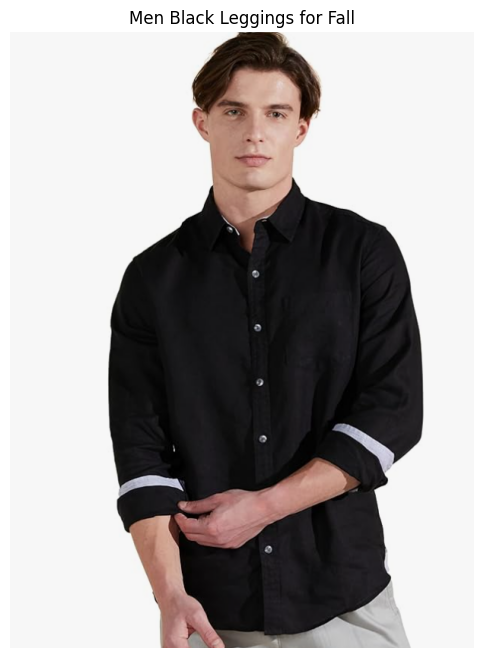

In [ ]:
def predict_fashion_attributes(model, label_encoder, image_path, device=None):
    
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    
    model.eval()
    model = model.to(device)
    
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  
    
    
    with torch.no_grad():
        outputs = model(image_tensor)
    
    
    predicted_indices = {}
    for category in ["color", "type", "season", "gender"]:
        _, pred_idx = torch.max(outputs[category], 1)
        predicted_indices[category] = pred_idx.item()
    
    
    predictions = {}
    for category, idx in predicted_indices.items():
        if idx >= 0:  
            try:
                
                predictions[category] = label_encoder.encoders[category].classes_[idx]
            except IndexError:
                predictions[category] = "unknown"
        else:
            predictions[category] = "unknown"
    
    return predictions


def main(image_path,weight):
    
    checkpoint = torch.load(weight, map_location=torch.device('cpu'))
    num_classes = checkpoint['num_classes']
    
    
    model = FashionClassifier(num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    
    import pickle
    with open('label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    
    
    
    predictions = predict_fashion_attributes(model, label_encoder, image_path)
    
    
    print("\nFashion Item Prediction Results:")
    print("==============================")
    print(f"Color: {predictions['color']}")
    print(f"Type: {predictions['type']}")
    print(f"Season: {predictions['season']}")
    print(f"Gender: {predictions['gender']}")
    
    
    try:
        import matplotlib.pyplot as plt
        img = Image.open(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title(f"{predictions['gender']} {predictions['color']} {predictions['type']} for {predictions['season']}")
        plt.axis('off')
        plt.show()
    except ImportError:
        print("Matplotlib not installed. Skipping image display.")


main(r"F:\Codemonk\ss1.png",weight=r"F:\Codemonk\weights\fashion_classifier_model_6k.pth")

### Since the Previous Inference Result is not good hence doing some further Fine tuning

In [ ]:
def continue_training_fashion_classifier(additional_epochs=5, learning_rate=0.001):
    
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader
    import pickle
    from tqdm import tqdm
    import torchvision.transforms as transforms
    
    
    image_dir = "./Dataset_highres/fashion-dataset/fashion-dataset/images"
    styles_dir = "./Dataset_highres/fashion-dataset/fashion-dataset/styles"
    
    # Set hyperparameters
    batch_size = 32
    n = 20000  # Use the same dataset size as original training
    
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load label encoder
    with open('./weights/label_encoder_20k.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    
    num_classes = label_encoder.get_num_classes()
    print("Number of classes per category:", num_classes)
    
    # Data transforms (same as original)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    
    full_dataset = FashionDataset(image_dir, styles_dir, transform=transform)
    
    
    if n < len(full_dataset):
        indices = list(range(n))
        dataset = torch.utils.data.Subset(full_dataset, indices)
        print(f"Dataset limited to {n} samples")
    else:
        dataset = full_dataset
    
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    
    model = FashionClassifier(num_classes, pretrained=False)  
    
    
    checkpoint = torch.load('./weights/fashion_classifier_model_continued.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    print("Successfully loaded previously trained model weights")
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in tqdm(range(additional_epochs)):
        print(f"\nEpoch {epoch+1}/{additional_epochs}")
        print("-" * 20)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = {
            "color": 0,
            "type": 0,
            "season": 0,
            "gender": 0
        }
        
        for batch_idx, batch_data in enumerate(train_loader):
            inputs, labels = batch_data
            inputs = inputs.to(device)
            
            batch_encoded_labels = {}
            
            
            for category in ["color", "type", "season", "gender"]:
                
                encoded_labels_list = []
                
                
                for i in range(len(inputs)):
                    
                    if isinstance(labels, dict):
                        
                        label_value = labels[category][i]
                    else:
                       
                        label_value = labels[i][category]
                    
                   
                    try:
                        encoded_value = label_encoder.encoders[category].transform([label_value])[0]
                    except ValueError:
                       
                        encoded_value = -1
                    
                    encoded_labels_list.append(encoded_value)
                
               
                batch_encoded_labels[category] = torch.tensor(encoded_labels_list, dtype=torch.long).to(device)
            
           
            optimizer.zero_grad()
            
           
            outputs = model(inputs)
            
           
            loss = 0
            batch_corrects = {}
            for category in ["color", "type", "season", "gender"]:
                category_loss = criterion(outputs[category], batch_encoded_labels[category])
                loss += category_loss
                
                # Calculate accuracy
                _, preds = torch.max(outputs[category], 1)
                correct = torch.sum(preds == batch_encoded_labels[category]).item()
                running_corrects[category] += correct
                batch_corrects[category] = correct / inputs.size(0)
            
            # Backward + optimize
            loss.backward()
            optimizer.step()
            
            # Print batch statistics
            running_loss += loss.item() * inputs.size(0)
            batch_loss = loss.item()
            
            if (batch_idx + 1) % 500 == 0 or (batch_idx + 1) == len(train_loader):
                print(f"Batch {batch_idx + 1}/{len(train_loader)}, Loss: {batch_loss:.4f}")
                for category in ["color", "type", "season", "gender"]:
                    print(f"    {category} Acc: {batch_corrects[category]:.4f}")
        
        # Print epoch training statistics
        epoch_loss = running_loss / len(train_dataset)
        print(f"\nTraining - Epoch {epoch+1} - Loss: {epoch_loss:.4f}")
        for category in ["color", "type", "season", "gender"]:
            epoch_acc = running_corrects[category] / len(train_dataset)
            print(f"Training - {category} Acc: {epoch_acc:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = {
            "color": 0,
            "type": 0,
            "season": 0,
            "gender": 0
        }
        
        with torch.no_grad():
            for batch_data in val_loader:
                inputs, labels = batch_data
                inputs = inputs.to(device)
                
                
                batch_encoded_labels = {}
                
                for category in ["color", "type", "season", "gender"]:
                    encoded_labels_list = []
                    
                    for i in range(len(inputs)):
                        if isinstance(labels, dict):
                            label_value = labels[category][i]
                        else:
                            label_value = labels[i][category]
                        
                        try:
                            encoded_value = label_encoder.encoders[category].transform([label_value])[0]
                        except ValueError:
                            encoded_value = -1
                        
                        encoded_labels_list.append(encoded_value)
                    
                    batch_encoded_labels[category] = torch.tensor(encoded_labels_list, dtype=torch.long).to(device)
                
                # Forward pass
                outputs = model(inputs)
                
               
                loss = 0
                for category in ["color", "type", "season", "gender"]:
                    category_loss = criterion(outputs[category], batch_encoded_labels[category])
                    loss += category_loss
                    
                   
                    _, preds = torch.max(outputs[category], 1)
                    val_corrects[category] += torch.sum(preds == batch_encoded_labels[category]).item()
                
                val_loss += loss.item() * inputs.size(0)
        
        
        epoch_val_loss = val_loss / len(val_dataset)
        print(f"\nValidation - Epoch {epoch+1} - Loss: {epoch_val_loss:.4f}")
        for category in ["color", "type", "season", "gender"]:
            epoch_val_acc = val_corrects[category] / len(val_dataset)
            print(f"Validation - {category} Acc: {epoch_val_acc:.4f}")
    
    print("\nAdditional training complete!")
    
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'num_classes': num_classes,
    }, 'fashion_classifier_model_continued.pth')
    
    return model, label_encoder

model, label_encoder = continue_training_fashion_classifier(additional_epochs=10, learning_rate=0.0045)

C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: White
Type: Kurtas
Season: Summer
Gender: Women


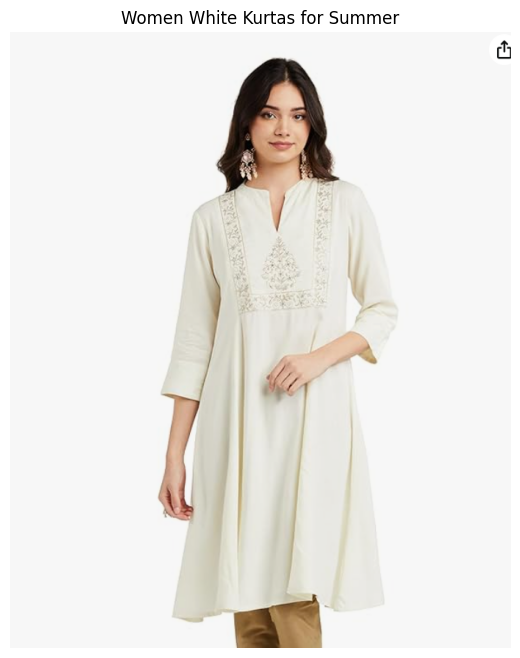

In [27]:
main(r"F:\Codemonk\ss2.png",weight=r"F:\Codemonk\fashion_classifier_model_continued.pth")

C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: Red
Type: Swimwear
Season: Summer
Gender: Women


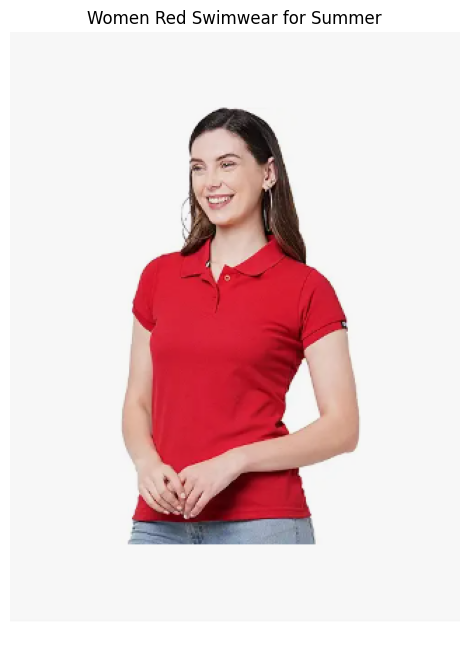

In [28]:
main(r"F:\Codemonk\ss3.png",weight=r"F:\Codemonk\fashion_classifier_model_continued.pth")

C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: Navy Blue
Type: Tshirts
Season: Fall
Gender: Women


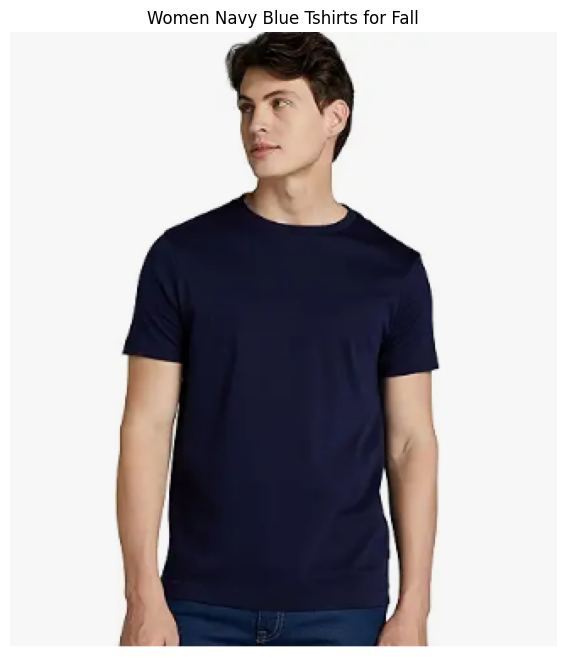

In [30]:
main(r"F:\Codemonk\ss5.png",weight=r"F:\Codemonk\fashion_classifier_model_continued.pth")

### Further Inference  with less LR to reduce the Val loss which is causing slight wrong predictions


In [35]:
model, label_encoder = continue_training_fashion_classifier(additional_epochs=6, learning_rate=0.002)

Using device: cuda:0
Number of classes per category: {'color': 44, 'type': 89, 'season': 4, 'gender': 5}
Dataset limited to 20000 samples


c:\Users\Priyanshu singh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Priyanshu singh\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\149269681.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for

Successfully loaded previously trained model weights


  0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/6
--------------------
Batch 500/500, Loss: 1.1531
    color Acc: 0.9375
    type Acc: 0.9375
    season Acc: 0.8750
    gender Acc: 0.8750

Training - Epoch 1 - Loss: 0.7729
Training - color Acc: 0.9043
Training - type Acc: 0.9693
Training - season Acc: 0.9246
Training - gender Acc: 0.9783


 17%|█▋        | 1/6 [45:06<3:45:34, 2706.89s/it]


Validation - Epoch 1 - Loss: 0.8183
Validation - color Acc: 0.9052
Validation - type Acc: 0.9633
Validation - season Acc: 0.9295
Validation - gender Acc: 0.9785

Epoch 2/6
--------------------
Batch 500/500, Loss: 0.2724
    color Acc: 0.9688
    type Acc: 0.9688
    season Acc: 1.0000
    gender Acc: 1.0000

Training - Epoch 2 - Loss: 0.4518
Training - color Acc: 0.9384
Training - type Acc: 0.9851
Training - season Acc: 0.9578
Training - gender Acc: 0.9904


 33%|███▎      | 2/6 [1:30:04<3:00:05, 2701.45s/it]


Validation - Epoch 2 - Loss: 6.0740
Validation - color Acc: 0.6877
Validation - type Acc: 0.6587
Validation - season Acc: 0.6785
Validation - gender Acc: 0.7897

Epoch 3/6
--------------------
Batch 500/500, Loss: 0.4432
    color Acc: 0.9062
    type Acc: 0.9688
    season Acc: 1.0000
    gender Acc: 1.0000

Training - Epoch 3 - Loss: 0.2875
Training - color Acc: 0.9608
Training - type Acc: 0.9915
Training - season Acc: 0.9725
Training - gender Acc: 0.9939


 50%|█████     | 3/6 [2:13:34<2:12:59, 2659.78s/it]


Validation - Epoch 3 - Loss: 0.9307
Validation - color Acc: 0.9000
Validation - type Acc: 0.9563
Validation - season Acc: 0.9280
Validation - gender Acc: 0.9730

Epoch 4/6
--------------------
Batch 500/500, Loss: 0.2291
    color Acc: 0.9688
    type Acc: 0.9688
    season Acc: 0.9688
    gender Acc: 1.0000

Training - Epoch 4 - Loss: 0.2071
Training - color Acc: 0.9712
Training - type Acc: 0.9938
Training - season Acc: 0.9797
Training - gender Acc: 0.9955


 67%|██████▋   | 4/6 [2:56:40<1:27:41, 2630.65s/it]


Validation - Epoch 4 - Loss: 1.8478
Validation - color Acc: 0.8337
Validation - type Acc: 0.8918
Validation - season Acc: 0.8303
Validation - gender Acc: 0.9270

Epoch 5/6
--------------------
Batch 500/500, Loss: 0.2411
    color Acc: 0.9375
    type Acc: 1.0000
    season Acc: 1.0000
    gender Acc: 1.0000

Training - Epoch 5 - Loss: 0.1645
Training - color Acc: 0.9796
Training - type Acc: 0.9952
Training - season Acc: 0.9839
Training - gender Acc: 0.9969


 83%|████████▎ | 5/6 [3:39:14<43:22, 2602.98s/it]  


Validation - Epoch 5 - Loss: 1.4263
Validation - color Acc: 0.8455
Validation - type Acc: 0.9267
Validation - season Acc: 0.8832
Validation - gender Acc: 0.9550

Epoch 6/6
--------------------
Batch 500/500, Loss: 0.6144
    color Acc: 0.9375
    type Acc: 0.9688
    season Acc: 0.9688
    gender Acc: 1.0000

Training - Epoch 6 - Loss: 0.1463
Training - color Acc: 0.9817
Training - type Acc: 0.9939
Training - season Acc: 0.9870
Training - gender Acc: 0.9968


100%|██████████| 6/6 [4:22:18<00:00, 2623.10s/it]


Validation - Epoch 6 - Loss: 4.0140
Validation - color Acc: 0.7380
Validation - type Acc: 0.7925
Validation - season Acc: 0.7328
Validation - gender Acc: 0.8630

Additional training complete!


C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: Black
Type: Tshirts
Season: Fall
Gender: Men


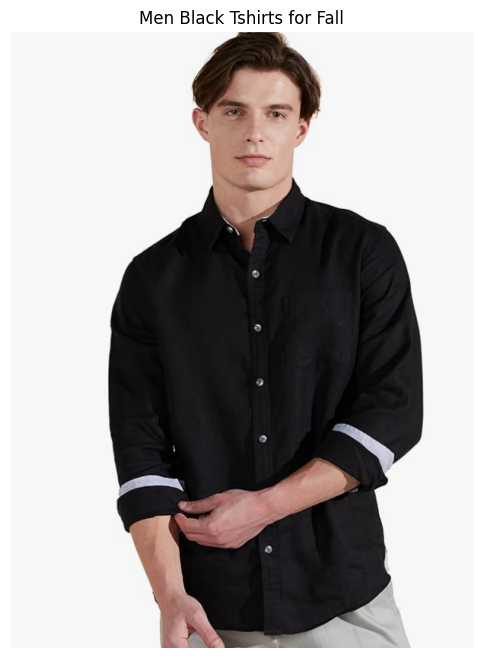

In [37]:
main(r"F:\Codemonk\ss1.png",weight=r"F:\Codemonk\fashion_classifier_model_continued.pth")

C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: White
Type: Kurtas
Season: Summer
Gender: Women


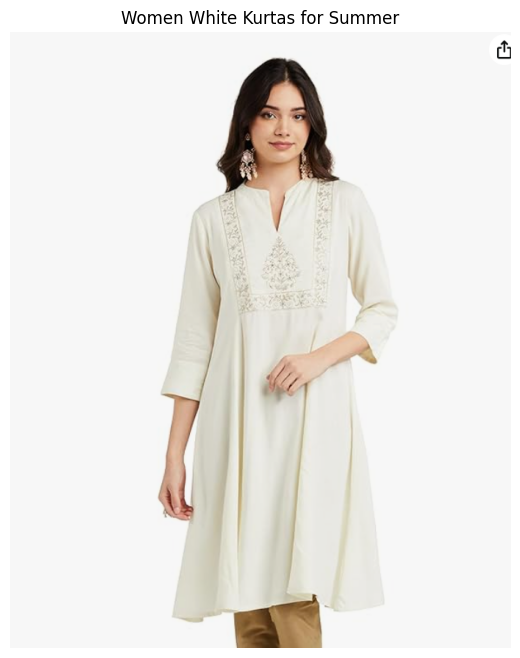

In [38]:
main(r"F:\Codemonk\ss2.png",weight=r"F:\Codemonk\fashion_classifier_model_continued.pth")

C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: Red
Type: Tops
Season: Summer
Gender: Women


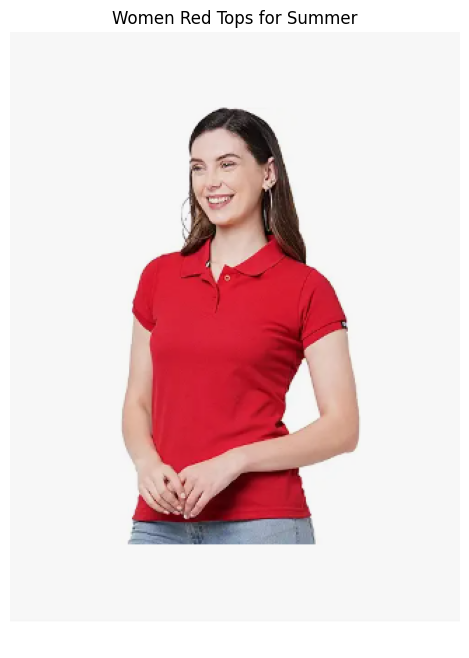

In [39]:
main(r"F:\Codemonk\ss3.png",weight=r"F:\Codemonk\fashion_classifier_model_continued.pth")

C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: Navy Blue
Type: Trousers
Season: Summer
Gender: Men


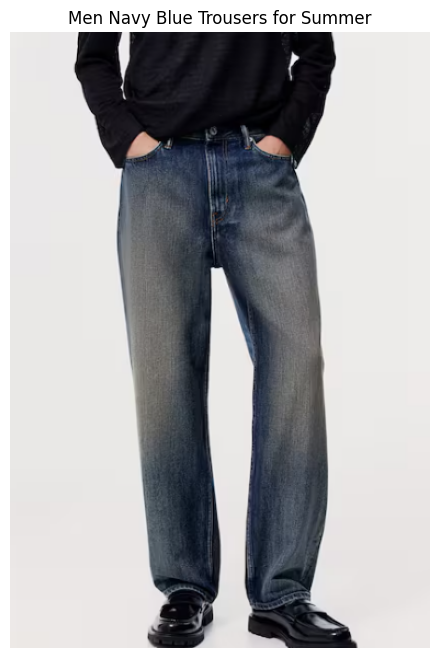

In [42]:
main(r"F:\Codemonk\ss4.png",weight=r"F:\Codemonk\fashion_classifier_model_continued.pth")

C:\Users\Priyanshu singh\AppData\Local\Temp\ipykernel_23052\2474780608.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weight, map_location=torc


Fashion Item Prediction Results:
Color: Black
Type: Backpacks
Season: Fall
Gender: Men


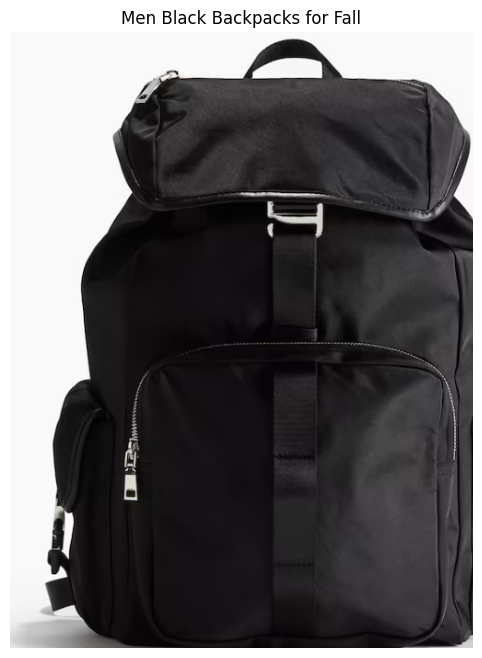

In [45]:
main(r"F:\Codemonk\ss6.png",weight=r"F:\Codemonk\fashion_classifier_model_continued.pth")